=== Shapiro-Wilk Test auf Normalität der F1-Differenzen ===
NeuralNet vs RandomForest: W = 0.9343, p = 0.1866
NeuralNet vs lasso: W = 0.9455, p = 0.3036
NeuralNet vs lassonet: W = 0.9408, p = 0.2482
RandomForest vs lasso: W = 0.9760, p = 0.8734
RandomForest vs lassonet: W = 0.9607, p = 0.5586
lasso vs lassonet: W = 0.9604, p = 0.5527

=== Pairwise Statistical Test Results ===


,Model 1,Model 2,Paired t-stat,Paired t-pval,Wilcoxon stat,Wilcoxon pval
0,NeuralNet,RandomForest,3.271059,0.004019,22.0,0.001017
1,NeuralNet,lasso,2.014021,0.058388,56.0,0.069580
2,NeuralNet,lassonet,-1.114616,0.278916,72.0,0.230513
3,RandomForest,lasso,-0.604767,0.552488,88.0,0.545876
4,RandomForest,lassonet,-3.774042,0.001284,25.0,0.001690
5,lasso,lassonet,-2.588101,0.018037,44.0,0.021484


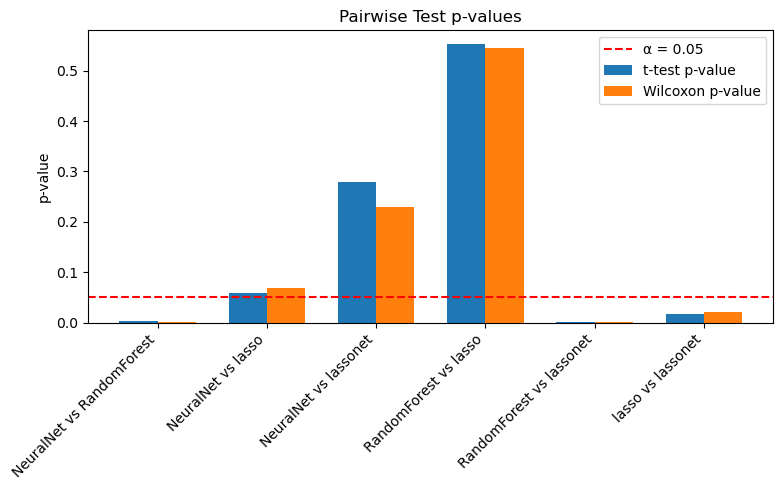

In [2]:
# Statistical Comparison of F1-Scores per Iteration und Modell
import pandas as pd
import numpy as np
import itertools
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.pyplot as plt

df = pd.read_csv("../results/all_model_results.csv")

# 2) Fehlende Werte bereinigen
df = df.dropna(subset=['best_f1', 'iteration', 'model_name'])

# 3) Pivot: Iteration als Zeilen, Modelle als Spalten
f1_pivot = df.pivot(index='iteration', columns='model_name', values='best_f1')

# 4) Shapiro-Wilk Test auf Normalität der Differenzen drucken
print("=== Shapiro-Wilk Test auf Normalität der F1-Differenzen ===")
models = f1_pivot.columns.tolist()
for m1, m2 in itertools.combinations(models, 2):
    diffs = f1_pivot[m1] - f1_pivot[m2]
    stat, pval = shapiro(diffs)
    print(f"{m1} vs {m2}: W = {stat:.4f}, p = {pval:.4f}")
print()

# 5) Paarweise Tests: gepaarter t-Test und Wilcoxon
results = []
for m1, m2 in itertools.combinations(models, 2):
    x = f1_pivot[m1].values
    y = f1_pivot[m2].values

    t_stat, t_p  = ttest_rel(x, y)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except ValueError:
        w_stat, w_p = np.nan, np.nan

    results.append({
        'Model 1':        m1,
        'Model 2':        m2,
        'Paired t-stat':  t_stat,
        'Paired t-pval':  t_p,
        'Wilcoxon stat':  w_stat,
        'Wilcoxon pval':  w_p
    })

results_df = pd.DataFrame(results)

# 6) Ergebnisse als DataFrame anzeigen
print("=== Pairwise Statistical Test Results ===")
display(results_df)

# 7) P-Value-Balkendiagramm
x_labels = [f"{r['Model 1']} vs {r['Model 2']}" for r in results]
t_pvals   = results_df['Paired t-pval']
w_pvals   = results_df['Wilcoxon pval']
x_pos     = np.arange(len(x_labels))
width     = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x_pos - width/2, t_pvals, width, label='t-test p-value')
ax.bar(x_pos + width/2, w_pvals, width, label='Wilcoxon p-value')
ax.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel('p-value')
ax.set_title('Pairwise Test p-values')
ax.legend()
plt.tight_layout()
plt.show()
